In [4]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
from matplotlib import pyplot as plt

np.random.seed(42)

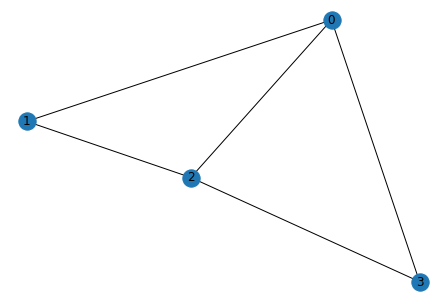

In [42]:
n_wires = 4
nodes = range(n_wires)
graph = [(0,1,0.5),(1,2,5),(2,0,1.5), (2,3,1.7), (0,3,0.5)] # input the edges here. 3rd element of each tuple is the weight. 
graphy = nx.Graph() 
graphy.add_nodes_from(nodes)
graphy.add_weighted_edges_from(graph) # change 1
nx.draw(graphy, with_labels=True)
plt.show() 

# unitary operator U_B with parameter beta
def U_B(beta):
    for wire in range(n_wires):
        qml.RX(2 * beta, wires=wire)


# unitary operator U_C with parameter gamma
def U_C(gamma):
    for edge in graph:
        wire1 = edge[0]
        wire2 = edge[1]
        weight = edge[2]
        qml.CNOT(wires=[wire1, wire2])
        qml.RZ(gamma*weight, wires=wire2)
        qml.CNOT(wires=[wire1, wire2])


In [34]:
def comp_basis_measurement(wires):
    n_wires = len(wires)
    # print(f'comp basis output: {qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)}')
    # return qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)
    hold = qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)
    # print(f'comp basis function output: {hold}')
    return hold

In [35]:
dev = qml.device("default.qubit", wires=n_wires, analytic=True, shots=1)

In [36]:
pauli_z = [[1, 0], [0, -1]]
pauli_z_2 = np.kron(pauli_z, pauli_z)


@qml.qnode(dev)
def circuit(gammas, betas, edge=None, n_layers=1):
    # apply Hadamards to get the n qubit |+> state
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    # p instances of unitary operators
    for i in range(n_layers):
        U_C(gammas[i])
        U_B(betas[i])
    if edge is None:
        # measurement phase
        # print(f'qml.sample(comp_basis_measurement(range(n_wires))): f{qml.sample(comp_basis_measurement(range(n_wires)))}')
        # return qml.sample(comp_basis_measurement(range(n_wires)))
        hold = qml.sample(comp_basis_measurement(range(n_wires)))
        # print(f"qml.sample(comp_basis_measurement(range(n_wires))): {hold}")
        return hold        
    # during the optimization phase we are evaluating a term
    # in the objective using expval
    return qml.expval(qml.Hermitian(pauli_z_2, wires=[edge[0], edge[1]])) # Change 2

In [44]:
def qaoa_maxcut(n_layers=1):
    print("\np={:d}".format(n_layers))

    # initialize the parameters near zero
    init_params = 0.01 * np.random.rand(2, n_layers) # change 4 -> maxcut unrelated, just so i can have 3 layers.
    params = init_params

    # minimize the negative of the objective function
    def objective(params):
        gammas = params[0]
        betas = params[1]
        neg_obj = 0
        for edge in graph:
            # objective for the MaxCut problem
            weight = edge[2]
            unweighted_obj = 0.5 * (1 - circuit(gammas, betas, edge=edge, n_layers=n_layers))
            weighted_obj = unweighted_obj * weight
            neg_obj -= weighted_obj # change 3
            # print(f'Edge: {edge} Unweighted: {unweighted_obj}')
            # print(f'Weighted: {weighted_obj}')
            
        return neg_obj

    # initialize optimizer: Adagrad works well empirically
    opt = qml.AdagradOptimizer(stepsize=0.5)

    # optimize parameters in objective
    params = init_params
    steps = 100
    for i in range(steps):
        params = opt.step(objective, params)
        if (i + 1) % 5 == 0:
            print("Objective after step {:5d}: {: .7f}".format(i + 1, -objective(params)))

    # sample measured bitstrings 100 times
    bit_strings = []
    n_samples = 100
    for i in range(0, n_samples):
        bit_strings.append(int(circuit(params[0], params[1], edge=None, n_layers=n_layers))) # This appends the integer from 0-15 (if 4 nodes) so it outputs the computational basis measurement in decimal. 
        # print(f"int circuit right before int-ing: {circuit(params[0], params[1], edge=None, n_layers=n_layers)}")
        # print(f"int circuit: {int(circuit(params[0], params[1], edge=None, n_layers=n_layers))}")

    # print optimal parameters and most frequently sampled bitstring
    counts = np.bincount(np.array(bit_strings))
    print(f'couts: {counts}')
    most_freq_bit_string = np.argmax(counts)
    print("Optimized (gamma, beta) vectors:\n{}".format(params[:, :n_layers]))
    print("Most frequently sampled bit string is: {:04b}".format(most_freq_bit_string))

    return -objective(params), bit_strings


# perform qaoa on our graph with p=1,2 and
# keep the bitstring sample lists
# bitstrings1 = qaoa_maxcut(n_layers=1)[1]
# bitstrings2 = qaoa_maxcut(n_layers=2)[1]
# bitstrings3 = qaoa_maxcut(n_layers=3)[1]
bitstrings7 = qaoa_maxcut(n_layers=7)[1]
bitstrings8 = qaoa_maxcut(n_layers=8)[1]


p=7
Objective after step     5:  4.3828511
Objective after step    10:  5.6033115
Objective after step    15:  6.6606668
Objective after step    20:  6.6182660
Objective after step    25:  7.2399256
Objective after step    30:  5.6116112
Objective after step    35:  7.1383145
Objective after step    40:  6.8591036
Objective after step    45:  7.0145845
Objective after step    50:  7.6335268
Objective after step    55:  6.2948091
Objective after step    60:  7.4930113
Objective after step    65:  7.4896199
Objective after step    70:  7.1381641
Objective after step    75:  7.3321132
Objective after step    80:  7.6991462
Objective after step    85:  7.6838741
Objective after step    90:  7.4956887
Objective after step    95:  7.6877060
Objective after step   100:  7.6698559
couts: [ 2  1 22  0  0 18  1  0  1  1 20  0  0 33  0  1]
Optimized (gamma, beta) vectors:
[[-1.01841897 -1.13060148 -1.32068485 -0.76999057 -0.58143404 -1.51825028
  -0.63001362]
 [-0.35007895 -0.60413326  0.4526764

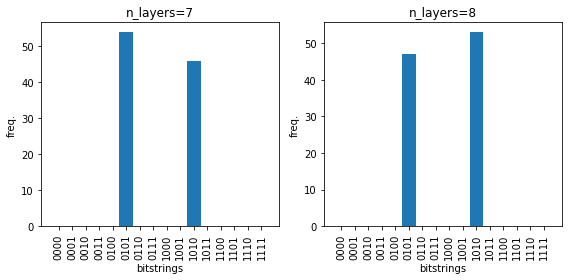

In [43]:
import matplotlib.pyplot as plt

xticks = range(0, 16)
xtick_labels = list(map(lambda x: format(x, "04b"), xticks))
bins = np.arange(0, 17) - 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("n_layers=7")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings7, bins=bins)
plt.subplot(1, 2, 2)
plt.title("n_layers=8")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings8, bins=bins)
plt.tight_layout()
plt.show()